# Functions to denoise and detone a covariance matrix

References: López de Prado, Marcos. Machine Learning for Asset Managers. United States, Cambridge University Press, 2020.

## Noise and Signal

In systematic investing, covariance matrix is one of the key instruments to build a portfolio. Unfortunately, we can’t just calculate it without treating some known problems. Roughly speaking, the cov matrix contains noise and signal and it’s necessary to separate it from each other to get more realistic results.

If we don’t do this, the results probably will be misleading and our conclusions will be based on information that happened randomly. We want to find patterns, randomness is a bad thing here. How do we separate noise from signal?

We can consider that eigenvalues that are in the range of the maximum and minimum eigenvalues are consistent with random behavior, the remaining is considered signal. 

The next step is:

   •	Generate a random matrix
   
   •	Calculate the correlation matrix
   
   •	Get the Eigenvalues and Eigenvectors
   
   •	Calculate the Marchenko-Pastur PDF and an empirical KDE


0.030204081632653063


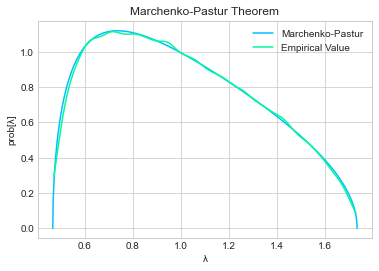

In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV, LeaveOneOut, KFold
from scipy.optimize import minimize
from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

#Marchenko - Pastur PDF Python function
def mpPDF(var, q, pts):
    """
    Creates a Marchenko-Pastur Probability Density Function
    Args:
    var (float): Variance
    q (float): T/N where T is the time period and N the number of stocks
    pts (int): Number of points used to construct the PDF
    Returns:
    pd.Series: Marchenko-Pastur PDF
    """
    # Marchenko-Pastur pdf
    # q=T/N
    # Adjusting code to work with 1 dimension arrays
    if isinstance(var, np.ndarray):
        if var.shape == (1,):
            var = var[0]
    
    # calculate minimum and maximum expected eigenvalues
    eMin, eMax = var * (1 - (1. / q) ** .5) ** 2, var * (1 + (1. / q) ** .5) ** 2
    eVal = np.linspace(eMin, eMax, pts)
    pdf = q / (2 * np.pi * var * eVal) * ((eMax - eVal) * (eVal - eMin)) ** .5
    pdf = pd.Series(pdf, index=eVal)
    return pdf


# Getting Eigenvalues and Eigenvectors from a Hermitian matrix
def getPCA(matrix):
    """
    Gets the Eigenvalues and Eigenvector values from a Hermitian Matrix
    Args:
    matrix pd.DataFrame: Correlation matrix

    Returns:
    (tuple): tuple containing:
    np.ndarray: Eigenvalues of correlation matrix
    np.ndarray: Eigenvectors of correlation matrix


    """
    # Get eVal,eVec from a Hermitian matrix
    eVal, eVec = np.linalg.eigh(matrix)
    indices = eVal.argsort()[::-1]  # arguments for sorting eVal desc
    eVal, eVec = eVal[indices], eVec[:, indices]
    eVal = np.diagflat(eVal)
    return eVal, eVec


"""
Added function to find the optimal KDE bandwidth using cross-validation
"""
#Cross validation for optimal KDE bandwidth selection
def optimalBandwidthKDE(obs,lower,upper,step):
    if len(obs.shape) == 1:
        obs = obs.reshape(-1, 1)
    grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': np.linspace(lower, upper, step)},
                    cv=LeaveOneOut(),n_jobs=-1) # leave-one-out CV or Kfold depending on requirements
    grid.fit(obs)
    optimalBandwidth=grid.best_params_.get('bandwidth')    
    return optimalBandwidth


#Kernel Density Estimation
def fitKDE(obs, bWidth=.25, kernel='gaussian', x=None):
    """
    Fit kernel to a series of obs, and derive the prob of obs x is the array of values
    on which the fit KDE will be evaluated. It is the empirical PDF
    Args:
    obs (np.ndarray): observations to fit. Commonly is the diagonal of Eigenvalues
    bWidth (float): The bandwidth of the kernel. Default is .25
    kernel (str): The kernel to use. Valid kernels are [‘gaussian’|’tophat’|
    ’epanechnikov’|’exponential’|’linear’|’cosine’] Default is ‘gaussian’.
    x (np.ndarray): x is the array of values on which the fit KDE will be evaluated

    Returns:
    pd.Series: Empirical PDF
    """

    if len(obs.shape) == 1:
        obs = obs.reshape(-1, 1)
    kde = KernelDensity(kernel=kernel, bandwidth=bWidth).fit(obs)
    if x is None:
        x = np.unique(obs).reshape(-1, 1)
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
    logProb = kde.score_samples(x)  # log(density)
    pdf = pd.Series(np.exp(logProb), index=x.flatten())
    return pdf


#Proving Marchenko - Pastur
# Generating a random matrix
x = np.random.normal(size=(10000, 1000))
# Getting eigenvalues and eigenvectors
eVal0, eVec0 = getPCA(np.corrcoef(x, rowvar=0))
# Marchenko-Pastur pdf
pdf0 = mpPDF(1., q=x.shape[0] / float(x.shape[1]), pts=1000)
# Empirical pdf
bWidth = optimalBandwidthKDE(np.diag(eVal0),0.01,1,50)
print(bWidth)
pdf1 = fitKDE(np.diag(eVal0), bWidth=bWidth)


# Plotting results
ax = pdf0.plot(title="Marchenko-Pastur Theorem", label="Marchenko-Pastur", color="deepskyblue")
pdf1.plot(label="Empirical Value", color="mediumspringgreen")
ax.set(xlabel="λ", ylabel="prob[λ]")
ax.legend(loc="upper right")


As we can see, the empirical result similar to the theory. So we can say that MP can be applied in the real world.
You’ve noticed that, in this example, we only have noise. What if we test the same thing with a matrix with signal? This is our final step.

Now we’re going to:

•	Create a matrix random matrix

•	Calculate the covariation matrix

•	Add a signal to the covariation matrix

•	Convert to correlation

•	Get the max eigenvalue and the noise variance

•	Calculate the Empirical and MP PDF


1.182780610309416
0.05040816326530612
Variance =  0.6827191742814815


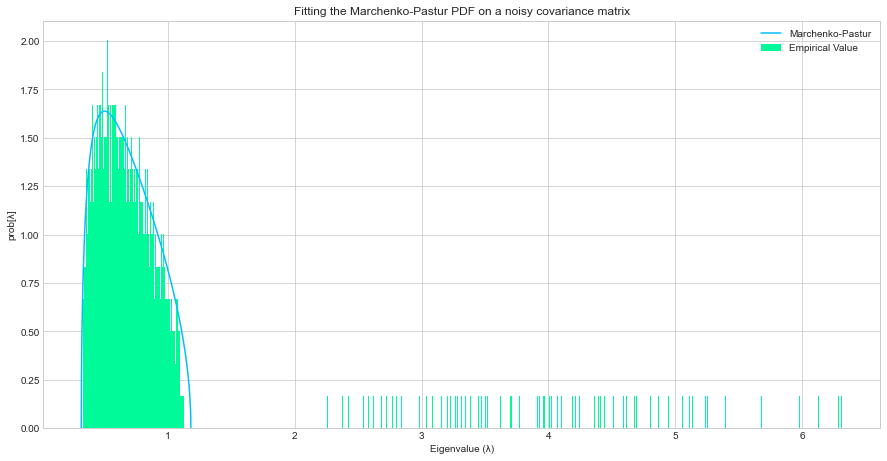

In [2]:
def getRndCov(nCols, nFacts):
    """
    Generates a Random Covariance Matrix
    Args:
    nCols (int): number of columns of random normal. This will be the dimensions of
    the output
    nFacts (int): number of rows of random normal

    Returns:
    np.ndarray: random covariance matrix
    """
    w = np.random.normal(size=(nCols, nFacts))
    cov = np.dot(w, w.T)  # random cov matrix, however not full rank
    cov += np.diag(np.random.uniform(size=nCols))  # full rank cov
    return cov


def cov2corr(cov):
    """
    Derive the correlation matrix from a covariance matrix
    Args:
    cov (np.ndarray): covariance matrix

    Returns:
    np.ndarray: correlation matrix
    """
    std = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std, std)
    corr[corr < -1], corr[corr > 1] = -1, 1  # numerical error
    return corr


def errPDFs(var, eVal, q, bWidth, pts=1000):
    """
    Fit error of Empirical PDF (uses Marchenko-Pastur PDF)
    Args:
    var (float): Variance
    eVal (np.ndarray): Eigenvalues to fit.
    q (float): T/N where T is the number of rows and N the number of columns
    bWidth (float): The bandwidth of the kernel.
    pts (int): Number of points used to construct the PDF

    Returns:
    float: sum squared error
    """
    # Fit error
    pdf0 = mpPDF(var, q, pts)  # theoretical pdf
    pdf1 = fitKDE(eVal, bWidth, x=pdf0.index.values)  # empirical pdf    
    sse = np.sum((pdf1 - pdf0) ** 2)
    return sse


#def findMaxEval(eVal, q, bWidth):
def findMaxEval(eVal, q):
    """
    Find max random eVal by fitting Marchenko’s dist (i.e everything else larger than
    this, is a signal eigenvalue)
    Args:
    eVal (np.ndarray): Eigenvalues to fit on errPDFs
    q (float): T/N where T is the time period and N the number of stocks
    bWidth (float): The bandwidth of the kernel.

    Returns:
    (tuple): tuple containing:
    float: Maximum random eigenvalue
    float: Variance attributed to noise (1-result is one way to measure
    signal-to-noise)
    """
    bWidth = optimalBandwidthKDE(eVal,0.01,1,50)
    out = minimize(lambda *x: errPDFs(*x), .5, args=(eVal, q, bWidth),
                  bounds=((1E-5, 1 - 1E-5),))
    if out['success']:
        var = out['x'][0]
    else:
        var = 1
    eMax = var * (1 + (1. / q) ** .5) ** 2
    return eMax, var, bWidth

alpha, nCols, nFact, q = .995, 1000, 100, 10
# Random Matrix
rand_matrix = np.random.normal(size=(nCols * q, nCols))
# Covariance Matrix
cov = np.cov(rand_matrix, rowvar=0)
# Adding signal to Covariance Matrix
cov = alpha * cov + (1 - alpha) * getRndCov(nCols, nFact)  # noise + signal
# Converting Covariance to Correlation
corr0 = cov2corr(cov)
# Getting Eigenvalues and Eigenvectors
eVal0, eVec0 = getPCA(corr0)

# Getting Max Eigenvalues and calculating variance attributed to noise
#eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth=0.01)
eMax0, var0, bWidth = findMaxEval(np.diag(eVal0), q)
print(eMax0)
print(bWidth)
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)

# Getting PDFs and plotting it
pdf0 = mpPDF(var0, q=10, pts=1000)
pdf1 = fitKDE(np.diag(eVal0), bWidth=bWidth)  # Empirical PDF

# Plotting PDFs
ax = pdf0.plot(title="Fitting the Marchenko-Pastur PDF on a noisy covariance matrix", label="Marchenko-Pastur", color="deepskyblue", figsize=(15, 7.5))
ax.hist(pd.Series(np.diag(eVal0)), density="norm", bins=1000, label="Empirical Value", color="mediumspringgreen")
ax.set(xlabel="Eigenvalue (λ)", ylabel="prob[λ]")
ax.legend(loc="upper right")

print("Variance = ", var0)



Everything on the right side of the chart is an eigenvalue associated with signal (i.e. cannot be associated with noise). Another interesting conclusion is that 1 minus σ² is the percentage of variance that can be attributed to signal. This is a way to measure signal to noise. The fitted distribution implies that Var = 68%, indicating that only about 32% of the variance can be attributed to signal.

## Denoising the covariance/correlation matrix

Its common in financial applications to shrink the covariance matrix due to ill-conditioning (Ledoit and Wolf 2004). However, shrinkage reduces the condition number without discriminating between noise and signal. Therefore, shrinkage can further eliminate an already weak signal. 

Two methods for denoising/shrinking without eliminating signal:
1. Constant residual eigenvalue method: Set a constant eigenvalue for all random eigenvectors and then reconstruct denoised covariance matrix based on eigenvector decomposition


2. Targeted shrinkage: method 1 above is preferable to shrinkage because it removes the noise while preserving the signal. In this method, shrinkage is applied directly to the random eigenvectors. The parameter alpha regulates the amount of shrinkage among the eigenvectors and eigenvalues associated with noise. alpha -> 0  for total shrinkage


In [3]:
#Denoising correlation matrix by constant residual eigenvalue
def denoisedCorr(eVal,eVec,nFacts):
    """
    Denoise the correlation matrix by constant residual eigenvalue method
    Args:
    eVal (np.ndarray): Eigenvalues.
    eVec (np.ndarray): Eigenvectors.
    nFacts: number of non-random eigenvalues

    Returns:
    np.ndarray: correlation matrix
    """
    #Remove noise from corr by fixing random eigenvalues
    eVal_=np.diag(eVal).copy()    
    eVal_[nFacts:]=eVal_[nFacts:].sum()/float(eVal_.shape[0]-nFacts)
    eVal_=np.diag(eVal_)
    corr1=np.dot(eVec,eVal_).dot(eVec.T)
    corr1=cov2corr(corr1)
    return corr1

# Function to convert correlation to covariance matrix
def corr2cov(corr, std):
    cov=corr*np.outer(std,std)
    return cov

# Function to denoise covariance matrix

def denoisedCov(cov0,q):
    """
    Denoise a covariance matrix using getPCA, findMaxEval, denoisedCorr and corr2cov functions
    
    Args:
    cov0 (np.ndarray): initial covariance matrix
    q (float): T/N where T is the time period and N the number of stocks
    

    Returns:
    np.ndarray: Denoised covariance matrix
    """
    
    corr0=cov2corr(cov0)
    eVal0,eVec0=getPCA(corr0)
    eMax0,var0,bWidth=findMaxEval(np.diag(eVal0),q)
    nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)
    corr1=denoisedCorr(eVal0,eVec0,nFacts0)
    cov1=corr2cov(corr1,np.diag(cov0)**.5)
    return cov1

#Denoising correlation matrix by targeted shrinkage
def denoisedCorr2(eVal,eVec,nFacts,alpha=0):
    """
    Denoise the correlation matrix by targeted shrinkage
    Args:
    eVal (np.ndarray): Eigenvalues.
    eVec (np.ndarray): Eigenvectors.
    nFacts: number of non-random eigenvalues
    alpha: term that regulates the amount of shrinkage

    Returns:
    np.ndarray: correlation matrix
    """
    #Remove noise from corr through targeted shrinkage
    eValL,eVecL=eVal[:nFacts,:nFacts], eVec[:,:nFacts]
    eValR,eVecR=eVal[nFacts:,nFacts:], eVec[:,nFacts:]
    corr0=np.dot(eVecL,eValL).dot(eVecL.T)
    corr1=np.dot(eVecR,eValR).dot(eVecR.T)
    corr2=corr0 + alpha*corr1 + (1-alpha)*np.diag(np.diag(corr1))
    return corr2
    


## Detoning the covariance/correlation matrix
Financial correlation matrices incorporate a market component which is usually characterised by the first eigenvector. The market component affects every item of the covariance matrix. More useful to remove the market component in the context of clustering - it is difficult to find dissimilarities across clusters if a correlation matrix has a strong market component. Detoning is used to remove the market component from the denoised correlation matrix.

However, the detoned matrix is singular because of removing an eigenvector. Although not an issue for clustering algorithms, it is an issue for optimization as the correlation matrix needs to be inverted. Instead we can optimize a portfolio on the selected non-zero principal components and map the optimal allocations back to the original basis.

In [4]:
# Detoned correlation matrix - remove market component (eigenvector with the largest eigenvalue)
def detonedCorr1(corr1):
    """
    Detone the correlation matrix by removing first eigenvector (market component)
    Note that there could be more than one eigenvector representing the market component so function would need adapting
    
    Args:
    corr1 (np.ndarray): denoised correlation matrix (note that corr0 is the original correlation matrix)
    
    Returns:
    np.ndarray: detoned correlation matrix
    
    Author: Raj Shah
    """
    eVal1,eVec1 = getPCA(corr1)
    #Remove first eigenvector/eigenvalue
    eValD,eVecD=eVal1[1:,1:], eVec1[:,1:]
    corr1=np.dot(eVecD,eValD).dot(eVecD.T)
    corr1=cov2corr(corr1)
    return corr1


def detonedCorr2(corr1):
    """
    Detone the correlation matrix by removing first eigenvector (market component)
    Note that there could be more than one eigenvector representing the market component so function would need adapting

    Args:
    corr1 (np.ndarray): denoised correlation matrix (note that corr0 is the original correlation matrix)

    Returns:
    np.ndarray: detoned correlation matrix

    Author: Raj Shah
    """

    eVal1, eVec1 = getPCA(corr1)
    # Get first eigenvector/eigenvalue
    eValM, eVecM = eVal1[:1, :1], eVec1[:, :1]
    corr_M = np.dot(eVecM, eValM).dot(eVecM.T)
    corr1 = corr1 - corr_M
    corr1 = cov2corr(corr1)
    return corr1

## Experimental results

This section aims to show the benefits from using denoised covariance matrices for optimization using Monte Carlo.

First step is to create a block-diagonal matrix of 10 blocks of size 50 each - stylised representation of a TRUE NON-EMPIRICAL detoned S&P500 correlation matrix where off diagonal elements within each block have a correlation of 0.5, and each block represents a Sector.

Variances are drawn from a uniform distribution bounded between 5% and 20%.
Means are drawn from a normal distribution with mean and standard deviation equal to the standard deviation from the covariance matrix.

Then use the covariance matrix generated from the above steps to draw a random matrix X of size TxN which is then used to derive the associate empirical covariance matrix and vector of means.

**From the simulation results below, denoising is much more effective than shrinkage.**

MINIMUM VARIANCE PORTFOLIO - SIMULATION RESULTS

Root mean squared error of simulations vs true portfolio

RMSE - Not denoised, not shrunk:  0.0102

**RMSE - Denoised, not shrunk:  0.0068**

RMSE - Not denoised, shrunk:  0.0102

RMSE - Denoised, shrunk:  0.0076

MAXIMIMUM SHARPE RATIO PORTFOLIO - SIMULATION RESULTS

Root mean squared error of simulations vs true portfolio

RMSE - Not denoised, not shrunk:  0.986

**RMSE - Denoised, not shrunk:  0.118**

RMSE - Not denoised, shrunk:  0.896

RMSE - Denoised, shrunk:  0.112

In [5]:
#Generate a block-diagonal covariance matrix and a vector of means

from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf

#Function to create block-diagonal matrix of 10 blocks of size 50 each - stylised representation of a true non-empirical
#detoned S&P500 correlation matrix where off diagonal elements within each block have a correlation of 0.5, and each block
#represents a Sector

def formBlockMatrix(nBlocks,bSize,bCorr):
    block=np.ones((bSize,bSize))*bCorr
    block[range(bSize),range(bSize)]=1
    corr=block_diag(*([block]*nBlocks))
    return corr

def formTrueMatrix(nBlocks,bSize,bCorr):
    corr0=formBlockMatrix(nBlocks,bSize,bCorr)
    corr0=pd.DataFrame(corr0)
    cols=corr0.columns.tolist()
    np.random.shuffle(cols)
    corr0=corr0[cols].loc[cols].copy(deep=True)
    std0=np.random.uniform(.05,.2,corr0.shape[0])
    cov0=corr2cov(corr0,std0)
    mu0=np.random.normal(std0,std0,cov0.shape[0]).reshape(-1,1)
    return mu0,cov0

nBlocks,bSize,bCorr=5,10,.5
np.random.seed(123)
mu0,cov0=formTrueMatrix(nBlocks,bSize,bCorr)

def simCovMu(mu0,cov0,nObs,shrink=False):
    '''
    This function receives arguments nObs which sets the value of T. When shrink=True, the function performs
    Ledoit-Wolf shrinkage on the empirical covariance matrix
    '''

    x=np.random.multivariate_normal(mu0.flatten(),cov0,size=nObs)
    mu1=x.mean(axis=0).reshape(-1,1)
    if shrink:cov1=LedoitWolf().fit(x).covariance_
    else:cov1=np.cov(x,rowvar=0)
    return mu1,cov1

def optPort(cov,mu=None):
    inv=np.linalg.inv(cov)
    ones=np.ones(shape=(inv.shape[0],1))
    if mu is None:mu=ones
    w=np.dot(inv,mu)
    w/=np.dot(ones.T,w)
    return w

#Simulations for Minimum variance portfolios
nObs,nTrials,shrink,minVarPortf=1000,1000,False,True
w1=pd.DataFrame(columns=range(cov0.shape[0]),index=range(nTrials),dtype=float)
w1_d=w1.copy(deep=True)
np.random.seed(123)
for i in range(nTrials):
    mu1,cov1=simCovMu(mu0,cov0,nObs,shrink=shrink)
    if minVarPortf:mu1=None
    cov1_d=denoisedCov(cov1,nObs*1./cov1.shape[1])
    w1.loc[i]=optPort(cov1,mu1).flatten()
    w1_d.loc[i]=optPort(cov1_d,mu1).flatten()
    
    
w0=optPort(cov0,None if minVarPortf else mu0)#True minimum variance portfolio
w0=np.repeat(w0.T,w1.shape[0],axis=0)
rmse=np.mean((w1-w0).values.flatten()**2)**.5 #RMSE
rmse_d=np.mean((w1_d-w0).values.flatten()**2)**.5 #RMSE

print("MINIMUM VARIANCE PORTFOLIO - SIMULATION RESULTS")
print("Root mean squared error of simulations vs true portfolio")
print("RMSE - Not denoised, not shrunk: ",rmse)
print("RMSE - Denoised, not shrunk: ",rmse_d)


nObs,nTrials,shrink,minVarPortf=1000,1000,True,True
w1=pd.DataFrame(columns=range(cov0.shape[0]),index=range(nTrials),dtype=float)
w1_d=w1.copy(deep=True)
np.random.seed(123)
for i in range(nTrials):
    mu1,cov1=simCovMu(mu0,cov0,nObs,shrink=shrink)
    if minVarPortf:mu1=None
    cov1_d=denoisedCov(cov1,nObs*1./cov1.shape[1])
    w1.loc[i]=optPort(cov1,mu1).flatten()
    w1_d.loc[i]=optPort(cov1_d,mu1).flatten()
    
    
w0=optPort(cov0,None if minVarPortf else mu0)#True minimum variance portfolio
w0=np.repeat(w0.T,w1.shape[0],axis=0)
rmse_s=np.mean((w1-w0).values.flatten()**2)**.5 #RMSE
rmse_s_d=np.mean((w1_d-w0).values.flatten()**2)**.5 #RMSE

print("RMSE - Not denoised, shrunk: ",rmse_s)
print("RMSE - Denoised, shrunk: ",rmse_s_d)

#Simulations for Maximum Sharpe ratio portfolios

nObs,nTrials,shrink,minVarPortf=1000,1000,False,False
w1=pd.DataFrame(columns=range(cov0.shape[0]),index=range(nTrials),dtype=float)
w1_d=w1.copy(deep=True)
np.random.seed(123)
for i in range(nTrials):
    mu1,cov1=simCovMu(mu0,cov0,nObs,shrink=shrink)
    if minVarPortf:mu1=None
    cov1_d=denoisedCov(cov1,nObs*1./cov1.shape[1])
    w1.loc[i]=optPort(cov1,mu1).flatten()
    w1_d.loc[i]=optPort(cov1_d,mu1).flatten()
    
    
w0=optPort(cov0,None if minVarPortf else mu0)#True minimum variance portfolio
w0=np.repeat(w0.T,w1.shape[0],axis=0)
rmse=np.mean((w1-w0).values.flatten()**2)**.5 #RMSE
rmse_d=np.mean((w1_d-w0).values.flatten()**2)**.5 #RMSE

print("MAXIMIMUM SHARPE RATIO PORTFOLIO - SIMULATION RESULTS")
print("Root mean squared error of simulations vs true portfolio")
print("RMSE - Not denoised, not shrunk: ",rmse)
print("RMSE - Denoised, not shrunk: ",rmse_d)


nObs,nTrials,shrink,minVarPortf=1000,1000,True,False
w1=pd.DataFrame(columns=range(cov0.shape[0]),index=range(nTrials),dtype=float)
w1_d=w1.copy(deep=True)
np.random.seed(123)
for i in range(nTrials):
    mu1,cov1=simCovMu(mu0,cov0,nObs,shrink=shrink)
    if minVarPortf:mu1=None
    cov1_d=denoisedCov(cov1,nObs*1./cov1.shape[1])
    w1.loc[i]=optPort(cov1,mu1).flatten()
    w1_d.loc[i]=optPort(cov1_d,mu1).flatten()
    
    
w0=optPort(cov0,None if minVarPortf else mu0)#True minimum variance portfolio
w0=np.repeat(w0.T,w1.shape[0],axis=0)
rmse_s=np.mean((w1-w0).values.flatten()**2)**.5 #RMSE
rmse_s_d=np.mean((w1_d-w0).values.flatten()**2)**.5 #RMSE

print("RMSE - Not denoised, shrunk: ",rmse_s)
print("RMSE - Denoised, shrunk: ",rmse_s_d)


exception calling callback for <Future at 0x1f70a508 state=finished returned list>
Traceback (most recent call last):
  File "\\shrusersprd.app.mondrian.mipl.com\users$\shahr1\research-virtualenvs\optimization\lib\site-packages\joblib\externals\loky\_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "\\shrusersprd.app.mondrian.mipl.com\users$\shahr1\research-virtualenvs\optimization\lib\site-packages\joblib\parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
  File "\\shrusersprd.app.mondrian.mipl.com\users$\shahr1\research-virtualenvs\optimization\lib\site-packages\joblib\parallel.py", line 792, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "\\shrusersprd.app.mondrian.mipl.com\users$\shahr1\research-virtualenvs\optimization\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "\\shrusersprd.app.mondrian.mipl.com\users$\shahr1\research-virtualenvs\optimization\li

exception calling callback for <Future at 0x1fdef848 state=finished returned list>
Traceback (most recent call last):
  File "\\shrusersprd.app.mondrian.mipl.com\users$\shahr1\research-virtualenvs\optimization\lib\site-packages\joblib\externals\loky\_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "\\shrusersprd.app.mondrian.mipl.com\users$\shahr1\research-virtualenvs\optimization\lib\site-packages\joblib\parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
  File "\\shrusersprd.app.mondrian.mipl.com\users$\shahr1\research-virtualenvs\optimization\lib\site-packages\joblib\parallel.py", line 792, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "\\shrusersprd.app.mondrian.mipl.com\users$\shahr1\research-virtualenvs\optimization\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "\\shrusersprd.app.mondrian.mipl.com\users$\shahr1\research-virtualenvs\optimization\li

KeyboardInterrupt: 